In [1]:
import numpy as np
import pandas as pd

def Ackley(x1, x2):
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1**2 + x2**2)))
    term2 = -np.exp(0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2)))
    return term1 + term2 + np.e + 20

def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    z = Ackley(x1, x2)
    return x1, x2, z

def create_dataframe(grid):
   x1, x2, z = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Spherical")

/tmp/ipykernel_695700/3623673326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


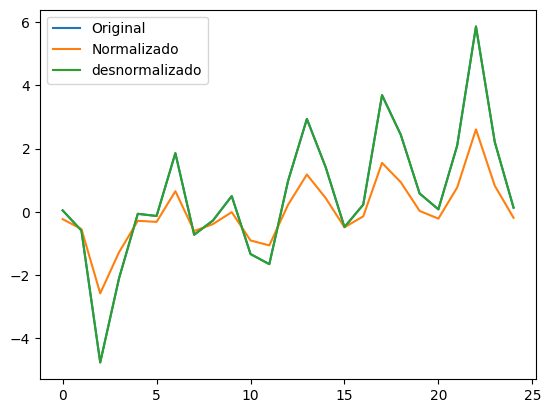

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects:   1% (1/53)
remote: Counting objects:   3% (2/53)
remote: Counting objects:   5% (3/53)
remote: Counting objects:   7% (4/53)
remote: Counting objects:   9% (5/53)
remote: Counting objects:  11% (6/53)
remote: Counting objects:  13% (7/53)
remote: Counting objects:  15% (8/53)
remote: Counting objects:  16% (9/53)
remote: Counting objects:  18% (10/53)
remote: Counting objects:  20% (11/53)
remote: Counting objects:  22% (12/53)
remote: Counting objects:  24% (13/53)
remote: Counting objects:  26% (14/53)
remote: Counting objects:  28% (15/53)
remote: Counting objects:  30% (16/53)
remote: Counting objects:  32% (17/53)
remote: Counting objects:  33% (18/53)
remote: Counting objects:  35% (19/53)
remote: Counting objects:  37% (20/53)
remote: Counting objects:  39% (21/53)
remote: Counting objects:  41% (22/53)
remote: Counting objects:  43% (23/53)
remote: Counting objects:  45% (24/53)
remote: Counting objects:  47% (25

Resolving deltas:  64% (20/31)
Resolving deltas:  67% (21/31)
Resolving deltas:  70% (22/31)
Resolving deltas:  74% (23/31)
Resolving deltas:  77% (24/31)
Resolving deltas:  80% (25/31)
Resolving deltas:  83% (26/31)
Resolving deltas:  87% (27/31)
Resolving deltas:  90% (28/31)
Resolving deltas:  93% (29/31)
Resolving deltas:  96% (30/31)
Resolving deltas: 100% (31/31)
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-09 19:53:14.217746: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 19:53:14.261818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 19:53:14.261852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 19:53:14.262691: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 19:53:14.268690: I tensorflow/core/platform/cpu_feature_guar

2024-09-09 19:53:16.793119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01


+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 61ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 60ms/step



 1/32 [..............................] - ETA: 1s


 9/32 [=======>......................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  20

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 1s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 1s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++

Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  27

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 1s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_8,0.950838,0.774254,0.793497,0.920250,0.204638,1.509562,0.738649,0.091737,0.955898,0.452369,4.146364,0.459494,133.173027,274.508199
model_1_2_7,0.943303,0.769220,0.784113,0.888428,0.236004,1.543227,0.772215,0.128344,1.097313,0.485802,4.628624,0.493453,132.887815,274.222987
model_1_2_6,0.942984,0.768790,0.783553,0.887170,0.237333,1.546105,0.774219,0.129791,1.096702,0.487168,4.649053,0.494840,132.876586,274.211759
model_1_2_5,0.936012,0.762682,0.777612,0.867499,0.266351,1.586944,0.795469,0.152419,1.160660,0.516092,5.095220,0.524220,132.645881,273.981053
model_1_2_4,0.934765,0.761141,0.776830,0.863829,0.271544,1.597251,0.798265,0.156640,1.171599,0.521099,5.175059,0.529305,132.607265,273.942437
model_1_2_3,0.904421,0.726570,0.773982,0.868213,0.397850,1.828429,0.808453,0.151597,1.158089,0.630753,7.117047,0.640687,131.843363,273.178535
model_1_2_2,0.899537,0.716011,0.778164,0.864262,0.418182,1.899038,0.793495,0.156142,1.079427,0.646670,7.429659,0.656854,131.743679,273.078851
model_1_2_1,0.897750,0.714188,0.777383,0.860902,0.425620,1.911228,0.796290,0.160007,1.088220,0.652396,7.544026,0.662670,131.708416,273.043589
model_1_2_0,0.895794,0.712421,0.776021,0.857681,0.433761,1.923042,0.801159,0.163713,1.100256,0.658605,7.669196,0.668978,131.670523,273.005696


DataFrame salvo em ../results/metrics_1_2


+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 50ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.971963,0.800442,0.785599,0.949405,0.116703,1.334444,0.766900,0.152714,0.727476,0.341618,2.794343,0.346999,134.296243,275.631416
model_1_3_8,0.971536,0.799143,0.789654,0.952327,0.118481,1.343128,0.752395,0.143893,0.747607,0.344210,2.821675,0.349631,134.266009,275.601181
model_1_3_7,0.968787,0.793643,0.797716,0.961519,0.129925,1.379912,0.723559,0.116149,0.798865,0.360451,2.997634,0.366128,134.081595,275.416767
model_1_3_6,0.968205,0.793276,0.797734,0.961173,0.132349,1.382366,0.723493,0.117194,0.807330,0.363799,3.034908,0.369528,134.044621,275.379793
model_1_3_5,0.964750,0.787503,0.799761,0.962858,0.146730,1.420968,0.716243,0.112106,0.840097,0.383053,3.256010,0.389086,133.838326,275.173499
model_1_3_4,0.963837,0.785544,0.798351,0.966789,0.150530,1.434068,0.721285,0.100244,0.891974,0.387981,3.314433,0.394092,133.787192,275.122364
model_1_3_3,0.963302,0.784323,0.798820,0.966041,0.152755,1.442232,0.719611,0.102500,0.832464,0.390839,3.348655,0.396995,133.757836,275.093009
model_1_3_2,0.962509,0.784085,0.797997,0.965849,0.156059,1.443825,0.722555,0.103080,0.857543,0.395043,3.399452,0.401265,133.715041,275.050214
model_1_3_1,0.961802,0.783454,0.797490,0.965410,0.159002,1.448043,0.724365,0.104405,0.867229,0.398750,3.444698,0.405030,133.677678,275.012851
model_1_3_0,0.953383,0.776263,0.794442,0.957903,0.194045,1.496131,0.735268,0.127065,0.934838,0.440506,3.983500,0.447443,133.279327,274.614500


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.983033,0.809945,0.800647,0.983723,0.070626,1.270901,0.713072,0.104762,0.614483,0.265756,2.085895,0.269941,135.300713,276.635886
model_1_4_8,0.982433,0.809254,0.800482,0.983012,0.073122,1.275519,0.713666,0.109342,0.621431,0.270411,2.124276,0.274670,135.231243,276.566416
model_1_4_7,0.981262,0.808057,0.795567,0.981292,0.077996,1.283525,0.731245,0.120408,0.605937,0.279277,2.199205,0.283675,135.102204,276.437377
model_1_4_6,0.980914,0.807821,0.795224,0.980946,0.079447,1.285102,0.732474,0.122635,0.612141,0.281863,2.221514,0.286302,135.065340,276.400513
model_1_4_5,0.980852,0.807197,0.794515,0.980946,0.079704,1.289272,0.735006,0.122637,0.613463,0.282318,2.225466,0.286765,135.058879,276.394052
model_1_4_4,0.980486,0.806954,0.793935,0.980429,0.081227,1.290902,0.737081,0.125967,0.618004,0.285003,2.248882,0.289491,135.021023,276.356196
model_1_4_3,0.980113,0.806689,0.793619,0.980060,0.082782,1.292671,0.738212,0.128343,0.623234,0.287718,2.272791,0.292249,134.983097,276.318270
model_1_4_2,0.979699,0.806422,0.793480,0.979418,0.084505,1.294459,0.738709,0.132471,0.625434,0.290697,2.299281,0.295275,134.941899,276.277072
model_1_4_1,0.976524,0.803468,0.791569,0.976794,0.097720,1.314212,0.745547,0.149364,0.670206,0.312601,2.502466,0.317525,134.651306,275.986478
model_1_4_0,0.972499,0.800820,0.786373,0.972376,0.114476,1.331917,0.764131,0.177800,0.720086,0.338343,2.760095,0.343671,134.334786,275.669959


DataFrame salvo em ../results/metrics_1_4


+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  29

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.991435,0.819310,0.813195,0.984182,0.035651,1.208273,0.668192,0.046763,0.491447,0.188815,1.548144,0.191788,136.667956,278.003128
model_1_5_8,0.991320,0.819232,0.813032,0.984307,0.036130,1.208795,0.668775,0.046396,0.491735,0.190079,1.555512,0.193073,136.641252,277.976425
model_1_5_7,0.990410,0.818239,0.811511,0.984040,0.039917,1.215435,0.674216,0.047184,0.501585,0.199792,1.613734,0.202939,136.441908,277.777081
model_1_5_6,0.990234,0.818117,0.811374,0.983837,0.040652,1.216255,0.674704,0.047785,0.504891,0.201624,1.625040,0.204799,136.405402,277.740575
model_1_5_5,0.990047,0.817953,0.810972,0.983565,0.041428,1.217350,0.676141,0.048588,0.510307,0.203539,1.636969,0.206745,136.367590,277.702762
model_1_5_4,0.989901,0.817738,0.811074,0.983486,0.042036,1.218784,0.675779,0.048822,0.511781,0.205026,1.646310,0.208255,136.338474,277.673646
model_1_5_3,0.989734,0.817629,0.810799,0.983365,0.042731,1.219516,0.676762,0.049181,0.513978,0.206716,1.657006,0.209971,136.305645,277.640817
model_1_5_2,0.989584,0.817439,0.810696,0.983297,0.043357,1.220786,0.677128,0.049381,0.515053,0.208224,1.666631,0.211504,136.276559,277.611731
model_1_5_1,0.988288,0.815787,0.808201,0.982777,0.048750,1.231831,0.686055,0.050918,0.533576,0.220794,1.749543,0.224271,136.042104,277.377277
model_1_5_0,0.987998,0.815500,0.807738,0.982000,0.049960,1.233752,0.687711,0.053216,0.546569,0.223516,1.768141,0.227036,135.993085,277.328257


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 69ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.995820,0.822685,0.816363,0.995482,0.017401,1.185704,0.656858,0.012099,0.359073,0.131914,1.267551,0.133992,138.102409,279.437581
model_1_6_8,0.995751,0.822504,0.816505,0.995278,0.017687,1.186916,0.656350,0.012646,0.359663,0.132993,1.271943,0.135087,138.069844,279.405017
model_1_6_7,0.995261,0.821933,0.815460,0.995643,0.019724,1.190733,0.660090,0.011669,0.380032,0.140443,1.303265,0.142655,137.851819,279.186992
model_1_6_6,0.995176,0.821828,0.815431,0.995609,0.020081,1.191435,0.660194,0.011759,0.383435,0.141709,1.308757,0.143941,137.815923,279.151095
model_1_6_5,0.994677,0.821428,0.815035,0.995870,0.022158,1.194112,0.661609,0.011061,0.400948,0.148854,1.340678,0.151198,137.619155,278.954328
model_1_6_4,0.993799,0.820924,0.814118,0.996410,0.025812,1.197479,0.664890,0.009614,0.432667,0.160661,1.396865,0.163191,137.313841,278.649014
model_1_6_3,0.993688,0.820821,0.814078,0.996415,0.026276,1.198169,0.665031,0.009601,0.435592,0.162098,1.403995,0.164650,137.278227,278.613399
model_1_6_2,0.992972,0.819986,0.813331,0.996532,0.029253,1.203753,0.667705,0.009288,0.455554,0.171036,1.449778,0.173730,137.063524,278.398697
model_1_6_1,0.991726,0.819626,0.813010,0.996505,0.034439,1.206162,0.668854,0.009359,0.485414,0.185578,1.529511,0.188501,136.737123,278.072295
model_1_6_0,0.991562,0.819570,0.812889,0.996434,0.035122,1.206534,0.669285,0.009550,0.490602,0.187409,1.540015,0.190361,136.697839,278.033012


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 87ms/step



 1/32 [..............................] - ETA: 1s


 3/32 [=>............................] - ETA: 0s


 9/32 [=======>......................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 7ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++

Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  19

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.995902,0.822805,0.816604,0.998051,0.017056,1.184906,0.655995,0.011079,0.356180,0.130599,1.262243,0.132656,138.142492,279.477664
model_1_7_2,0.996191,0.822659,0.816038,0.998192,0.015855,1.185883,0.658022,0.010279,0.351006,0.125915,1.243768,0.127898,138.288595,279.623767
model_1_7_1,0.996124,0.822543,0.815958,0.998164,0.016134,1.186656,0.658307,0.010438,0.353675,0.127019,1.248062,0.129020,138.253671,279.588844
model_1_7_3,0.996218,0.822543,0.815839,0.998182,0.015744,1.186658,0.658732,0.010339,0.349949,0.125475,1.242069,0.127451,138.302589,279.637761
model_1_7_6,0.997165,0.822113,0.816562,0.997875,0.011802,1.189528,0.656147,0.012080,0.285623,0.108636,1.181457,0.110347,138.878995,280.214168
model_1_7_5,0.996745,0.821618,0.816455,0.997710,0.013550,1.192843,0.656531,0.013023,0.308312,0.116406,1.208339,0.118239,138.602696,279.937869
model_1_7_4,0.996380,0.821433,0.815895,0.997673,0.015068,1.194078,0.658533,0.013230,0.327066,0.122751,1.231671,0.124684,138.390396,279.725568
model_1_7_7,0.997377,0.821178,0.817545,0.997682,0.010920,1.195781,0.652633,0.013179,0.260998,0.104497,1.167894,0.106143,139.034370,280.369542
model_1_7_9,0.997934,0.820724,0.816942,0.997494,0.008599,1.198820,0.654789,0.014250,0.218289,0.092733,1.132218,0.094193,139.512127,280.847299
model_1_7_8,0.997747,0.820710,0.817530,0.997352,0.009380,1.198913,0.652686,0.015057,0.229536,0.096849,1.144215,0.098374,139.338423,280.673596


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 1s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_6,0.997309,0.823297,0.815069,0.986123,0.011200,1.181617,0.661487,0.034559,0.398363,0.105828,1.172196,0.107494,138.983771,280.318944
model_1_8_7,0.997061,0.823280,0.814452,0.983953,0.012236,1.181731,0.663696,0.039964,0.419623,0.110615,1.188127,0.112357,138.806799,280.141971
model_1_8_8,0.996830,0.823189,0.813788,0.981879,0.013193,1.182336,0.666069,0.045130,0.437081,0.114863,1.202854,0.116672,138.656063,279.991236
model_1_8_9,0.996682,0.823172,0.813317,0.980524,0.013811,1.182447,0.667755,0.048506,0.448117,0.117520,1.212346,0.119370,138.564602,279.899774
model_1_8_5,0.997788,0.823172,0.815961,0.990823,0.009207,1.182450,0.658296,0.022856,0.349857,0.095952,1.141556,0.097463,139.375645,280.710818
model_1_8_4,0.997919,0.823009,0.816331,0.992995,0.008664,1.183543,0.656973,0.017446,0.324872,0.093078,1.133204,0.094544,139.497272,280.832444
model_1_8_2,0.998320,0.822229,0.817496,0.997168,0.006993,1.188754,0.652805,0.007053,0.219045,0.083623,1.107517,0.084940,139.925739,281.260912
model_1_8_3,0.998286,0.822208,0.817375,0.996615,0.007136,1.188895,0.653239,0.008431,0.250519,0.084475,1.109720,0.085806,139.885177,281.220349
model_1_8_1,0.998196,0.821879,0.817406,0.997020,0.007510,1.191098,0.653127,0.007423,0.211583,0.086661,1.115470,0.088026,139.783010,281.118183
model_1_8_0,0.998104,0.820588,0.816445,0.997213,0.007891,1.199732,0.656566,0.006942,0.210635,0.088831,1.121326,0.090230,139.684064,281.019236


DataFrame salvo em ../results/metrics_1_8


+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step


2024-09-09 19:55:06.222955: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.997302,0.823635,0.814421,0.997632,0.011231,1.179351,0.663804,0.005083,0.404209,0.105979,1.172687,0.107648,138.978071,280.313244
model_1_9_7,0.997201,0.823558,0.814336,0.997551,0.011652,1.179869,0.664111,0.005255,0.411061,0.107943,1.179149,0.109643,138.904600,280.239773
model_1_9_8,0.997246,0.823548,0.814384,0.997573,0.011464,1.179938,0.663937,0.005209,0.407732,0.107068,1.176256,0.108754,138.937155,280.272328
model_1_9_6,0.997164,0.823521,0.814265,0.997557,0.011804,1.180116,0.664363,0.005242,0.413379,0.108648,1.181496,0.110359,138.878563,280.213736
model_1_9_5,0.997100,0.823442,0.814220,0.997483,0.012072,1.180643,0.664523,0.005401,0.417755,0.109872,1.185608,0.111602,138.833758,280.168930
model_1_9_4,0.997043,0.823383,0.814171,0.997414,0.012310,1.181040,0.664698,0.005550,0.421759,0.110950,1.189269,0.112698,138.794690,280.129862
model_1_9_2,0.996950,0.823318,0.813961,0.997313,0.012696,1.181474,0.665451,0.005766,0.429106,0.112675,1.195201,0.114450,138.732975,280.068148
model_1_9_3,0.996985,0.823310,0.814034,0.997360,0.012549,1.181530,0.665189,0.005666,0.425511,0.112021,1.192938,0.113785,138.756292,280.091465
model_1_9_1,0.996904,0.823251,0.813815,0.997285,0.012887,1.181919,0.665974,0.005827,0.431940,0.113521,1.198143,0.115309,138.703057,280.038230
model_1_9_0,0.996848,0.823217,0.813731,0.997242,0.013120,1.182150,0.666275,0.005918,0.435211,0.114541,1.201719,0.116345,138.667277,280.002449


DataFrame salvo em ../results/metrics_1_9


+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_3,0.998358,0.825068,0.815229,0.998171,0.006836,1.169773,0.660915,0.004833,0.341170,0.082679,1.105104,0.083981,139.971141,281.306313
model_1_10_4,0.998379,0.825068,0.815238,0.998136,0.006747,1.169774,0.660882,0.004926,0.340022,0.082139,1.103735,0.083433,139.997351,281.332523
model_1_10_9,0.998519,0.825008,0.815830,0.997670,0.006163,1.170174,0.658767,0.006156,0.333147,0.078507,1.094764,0.079744,140.178253,281.513426
model_1_10_8,0.998501,0.825001,0.815877,0.997707,0.006241,1.170222,0.658598,0.006057,0.334215,0.079002,1.095961,0.080246,140.153154,281.488326
model_1_10_7,0.998490,0.824958,0.816087,0.997752,0.006286,1.170507,0.657847,0.005939,0.333489,0.079286,1.096652,0.080534,140.138792,281.473965
model_1_10_6,0.998464,0.824897,0.816131,0.997748,0.006393,1.170917,0.657689,0.005950,0.335354,0.079954,1.098289,0.081213,140.105210,281.440382
model_1_10_5,0.998466,0.824791,0.815636,0.997794,0.006387,1.171621,0.659460,0.005828,0.335922,0.079916,1.098196,0.081175,140.107109,281.442282
model_1_10_2,0.998151,0.824615,0.815017,0.998240,0.007695,1.172797,0.661674,0.004649,0.354046,0.087720,1.118308,0.089101,139.734444,281.069617
model_1_10_1,0.998081,0.824558,0.814862,0.998219,0.007987,1.173178,0.662227,0.004706,0.358849,0.089371,1.122805,0.090778,139.659841,280.995014
model_1_10_0,0.997742,0.824003,0.815403,0.998063,0.009397,1.176890,0.660293,0.005117,0.372488,0.096939,1.144483,0.098465,139.334711,280.669884


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 54ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.998917,0.826972,0.818005,0.993302,0.004506,1.157036,0.650984,0.008927,0.277594,0.067127,1.069281,0.068184,140.804690,282.139863
model_1_11_8,0.998911,0.826858,0.817964,0.993380,0.004531,1.157799,0.651133,0.008823,0.277517,0.067314,1.069667,0.068374,140.793574,282.128747
model_1_11_7,0.998811,0.825956,0.816006,0.992851,0.004950,1.163835,0.658135,0.009527,0.301370,0.070353,1.076100,0.071461,140.616932,281.952104
model_1_11_5,0.998779,0.825875,0.815953,0.992844,0.005083,1.164374,0.658324,0.009536,0.303809,0.071296,1.078154,0.072419,140.563679,281.898851
model_1_11_6,0.998799,0.825849,0.815882,0.992851,0.004999,1.164546,0.658578,0.009528,0.303794,0.070702,1.076858,0.071816,140.597104,281.932276
model_1_11_4,0.998737,0.825810,0.815890,0.992691,0.005256,1.164811,0.658550,0.009741,0.310755,0.072499,1.080814,0.073641,140.496740,281.831912
model_1_11_3,0.998616,0.825456,0.815905,0.992373,0.005762,1.167175,0.658499,0.010165,0.322272,0.075911,1.088600,0.077106,140.312778,281.647951
model_1_11_2,0.998604,0.825419,0.815980,0.992383,0.005811,1.167427,0.658227,0.010152,0.322761,0.076232,1.089351,0.077433,140.295889,281.631061
model_1_11_1,0.998549,0.825177,0.815882,0.992258,0.006041,1.169045,0.658581,0.010318,0.329771,0.077721,1.092876,0.078945,140.218511,281.553684
model_1_11_0,0.998536,0.825128,0.815924,0.992284,0.006095,1.169372,0.658427,0.010283,0.330979,0.078072,1.093716,0.079301,140.200499,281.535672


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_2,0.999084,0.827658,0.819149,0.999691,0.003812,1.152455,0.646892,0.001789,0.251192,0.061742,1.058613,0.062715,141.139135,282.474307
model_1_12_3,0.999093,0.827652,0.819136,0.999690,0.003774,1.152489,0.646940,0.001794,0.250430,0.061435,1.058030,0.062403,141.159104,282.494276
model_1_12_4,0.999118,0.827563,0.819093,0.999686,0.003672,1.153089,0.647093,0.001819,0.246423,0.060593,1.056451,0.061548,141.214282,282.549454
model_1_12_1,0.999072,0.827556,0.819040,0.999686,0.003864,1.153137,0.647282,0.001820,0.252618,0.062160,1.059408,0.063139,141.112177,282.447349
model_1_12_0,0.998936,0.827041,0.818140,0.999637,0.004430,1.156580,0.650502,0.002106,0.274819,0.066558,1.068113,0.067607,140.838698,282.173871
model_1_12_6,0.999275,0.826989,0.818677,0.999699,0.003017,1.156926,0.648582,0.001743,0.210961,0.054925,1.046383,0.055790,141.607175,282.942348
model_1_12_5,0.999168,0.826778,0.819465,0.999646,0.003465,1.158334,0.645764,0.002049,0.224512,0.058866,1.053278,0.059793,141.329984,282.665156
model_1_12_7,0.999353,0.825585,0.817335,0.999586,0.002691,1.166317,0.653383,0.002398,0.181053,0.051879,1.041381,0.052696,141.835380,283.170552
model_1_12_9,0.999459,0.825302,0.819361,0.999581,0.002253,1.168205,0.646133,0.002430,0.147417,0.047462,1.034636,0.048210,142.191264,283.526437
model_1_12_8,0.999393,0.825286,0.818480,0.999556,0.002528,1.168316,0.649286,0.002573,0.158114,0.050284,1.038876,0.051076,141.960278,283.295451


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 48ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  42

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  20

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.999146,0.827516,0.814900,0.995983,0.003557,1.153399,0.662090,0.015674,0.163264,0.059637,1.054683,0.060576,141.277915,282.613087
model_1_13_8,0.999060,0.827370,0.813916,0.995540,0.003911,1.154374,0.665611,0.017404,0.168852,0.062542,1.060139,0.063526,141.087699,282.422871
model_1_13_7,0.999221,0.827211,0.814243,0.996516,0.003241,1.155439,0.664443,0.013595,0.163621,0.056929,1.049830,0.057825,141.463808,282.798981
model_1_13_6,0.999527,0.826603,0.816405,0.998677,0.001969,1.159509,0.656710,0.005163,0.142839,0.044376,1.030277,0.045074,142.460262,283.795434
model_1_13_5,0.999534,0.826534,0.816527,0.998762,0.001939,1.159968,0.656273,0.004830,0.141467,0.044030,1.029807,0.044723,142.491578,283.826751
model_1_13_4,0.999590,0.826318,0.817732,0.999148,0.001707,1.161411,0.651960,0.003326,0.127090,0.041317,1.026247,0.041967,142.745945,284.081117
model_1_13_3,0.999604,0.826297,0.819436,0.999308,0.001647,1.161550,0.645868,0.002698,0.115536,0.040583,1.025323,0.041222,142.817639,284.152811
model_1_13_2,0.999572,0.826042,0.819903,0.999303,0.001783,1.163258,0.644198,0.002721,0.118354,0.042226,1.027415,0.042891,142.658852,283.994024
model_1_13_1,0.999538,0.825747,0.819550,0.999258,0.001921,1.165228,0.645460,0.002896,0.127210,0.043830,1.029537,0.044520,142.509764,283.844937
model_1_13_0,0.999524,0.825655,0.819488,0.999235,0.001982,1.165849,0.645679,0.002984,0.131495,0.044523,1.030478,0.045224,142.447015,283.782188


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 1s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_8,0.999496,0.827704,0.815869,0.999084,0.002096,1.152144,0.658625,0.002809,0.136136,0.045787,1.032233,0.046508,142.335029,283.670202
model_1_14_7,0.999491,0.827630,0.815784,0.999150,0.002120,1.152642,0.658931,0.002606,0.136310,0.046042,1.032594,0.046767,142.312782,283.647954
model_1_14_1,0.999176,0.827606,0.814450,0.998800,0.003428,1.152796,0.663703,0.003679,0.163890,0.058552,1.052712,0.059474,141.351349,282.686522
model_1_14_5,0.999466,0.827589,0.816053,0.999201,0.002223,1.152910,0.657969,0.002450,0.143870,0.047146,1.034175,0.047888,142.218066,283.553238
model_1_14_6,0.999477,0.827577,0.816087,0.999214,0.002177,1.152996,0.657847,0.002409,0.143183,0.046661,1.033475,0.047395,142.259423,283.594596
model_1_14_9,0.999506,0.827545,0.815856,0.999081,0.002055,1.153209,0.658673,0.002817,0.134706,0.045329,1.031592,0.046043,142.375215,283.710388
model_1_14_0,0.999154,0.827531,0.814445,0.998766,0.003520,1.153298,0.663720,0.003783,0.162922,0.059333,1.054127,0.060267,141.298363,282.633535
model_1_14_4,0.999364,0.827419,0.814361,0.999009,0.002646,1.154048,0.664019,0.003037,0.148986,0.051441,1.040686,0.052251,141.869258,283.204431
model_1_14_3,0.999357,0.827392,0.814430,0.999018,0.002676,1.154233,0.663772,0.003011,0.148837,0.051728,1.041141,0.052543,141.847016,283.182188
model_1_14_2,0.999348,0.827345,0.814487,0.999024,0.002716,1.154548,0.663568,0.002993,0.149347,0.052116,1.041760,0.052936,141.817156,283.152329


DataFrame salvo em ../results/metrics_1_14


+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 1s


15/32 [=============>................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_1,0.999519,0.828152,0.815742,0.999808,0.002001,1.149151,0.659081,0.001128,0.138732,0.044734,1.030768,0.045438,142.428103,283.763275
model_1_15_3,0.999556,0.827924,0.816043,0.999817,0.001850,1.150673,0.658005,0.001075,0.135992,0.043013,1.028446,0.043690,142.585041,283.920213
model_1_15_2,0.999549,0.827883,0.816051,0.999825,0.001876,1.150946,0.657974,0.001026,0.137050,0.043309,1.028839,0.043991,142.557594,283.892766
model_1_15_0,0.999514,0.827863,0.816216,0.999840,0.002024,1.151080,0.657385,0.000937,0.133946,0.044989,1.031120,0.045698,142.405338,283.740510
model_1_15_4,0.999598,0.827748,0.816052,0.999799,0.001672,1.151850,0.657972,0.001182,0.125098,0.040888,1.025704,0.041531,142.787719,284.122892
model_1_15_5,0.999605,0.827714,0.816008,0.999802,0.001643,1.152074,0.658129,0.001164,0.123918,0.040531,1.025258,0.041169,142.822740,284.157912
model_1_15_6,0.999638,0.827080,0.816978,0.999830,0.001506,1.156316,0.654661,0.000999,0.120145,0.038808,1.023157,0.039420,142.996470,284.331642
model_1_15_7,0.999652,0.826539,0.817160,0.999851,0.001448,1.159934,0.654009,0.000875,0.117882,0.038051,1.022261,0.038650,143.075330,284.410502
model_1_15_9,0.999624,0.826396,0.819173,0.999585,0.001563,1.160891,0.646806,0.002438,0.098625,0.039537,1.024035,0.040160,142.922044,284.257216
model_1_15_8,0.999639,0.826139,0.818735,0.999663,0.001502,1.162609,0.648376,0.001978,0.097779,0.038752,1.023089,0.039362,143.002299,284.337472


DataFrame salvo em ../results/metrics_1_15


+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 53ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  26

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.999685,0.826271,0.818243,0.999705,0.001312,1.161726,0.650133,0.001032,0.098019,0.036221,1.020172,0.036791,143.272489,284.607662
model_1_16_1,0.999688,0.826175,0.818242,0.999703,0.001298,1.162371,0.650138,0.001039,0.098303,0.036025,1.019954,0.036592,143.294189,284.629361
model_1_16_2,0.999729,0.825943,0.817019,0.999522,0.001127,1.163917,0.654514,0.001671,0.116018,0.033568,1.017325,0.034097,143.576741,284.911913
model_1_16_3,0.999735,0.825857,0.817097,0.999541,0.001102,1.164492,0.654235,0.001605,0.112588,0.033190,1.016937,0.033713,143.622002,284.957175
model_1_16_4,0.999739,0.825857,0.817061,0.999547,0.001086,1.164498,0.654363,0.001583,0.111284,0.032952,1.016695,0.033471,143.650800,284.985973
model_1_16_5,0.999729,0.825699,0.816748,0.999363,0.001128,1.165552,0.655483,0.002226,0.125580,0.033588,1.017346,0.034117,143.574306,284.909479
model_1_16_6,0.999710,0.825509,0.816134,0.999134,0.001208,1.166822,0.657677,0.003025,0.137055,0.034754,1.018571,0.035301,143.437872,284.773045
model_1_16_7,0.999701,0.825271,0.816003,0.999021,0.001247,1.168413,0.658148,0.003423,0.139851,0.035308,1.019168,0.035864,143.374590,284.709762
model_1_16_8,0.999728,0.824530,0.815922,0.999066,0.001133,1.173370,0.658437,0.003264,0.133014,0.033659,1.017419,0.034189,143.565880,284.901053
model_1_16_9,0.999729,0.824452,0.815891,0.999068,0.001128,1.173889,0.658548,0.003258,0.132878,0.033578,1.017336,0.034107,143.575478,284.910650


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  19

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.999717,0.823829,0.815506,0.999540,0.001179,1.178056,0.659925,0.002672,0.135544,0.034338,1.018128,0.034878,143.486063,284.821236
model_1_17_1,0.999723,0.823728,0.815617,0.999535,0.001155,1.178731,0.659526,0.002704,0.133155,0.033982,1.017755,0.034517,143.527688,284.862860
model_1_17_3,0.999623,0.822945,0.815981,0.999121,0.001568,1.183970,0.658225,0.005110,0.128428,0.039603,1.024114,0.040226,142.915432,284.250605
model_1_17_2,0.999616,0.822872,0.816073,0.999105,0.001597,1.184458,0.657896,0.005202,0.130291,0.039957,1.024547,0.040586,142.879827,284.214999
model_1_17_4,0.999531,0.822421,0.816186,0.998754,0.001950,1.187474,0.657491,0.007243,0.125881,0.044162,1.029986,0.044857,142.479571,283.814744
model_1_17_5,0.999534,0.822294,0.816026,0.998757,0.001938,1.188324,0.658064,0.007225,0.124510,0.044027,1.029804,0.044721,142.491772,283.826944
model_1_17_6,0.999522,0.821777,0.815573,0.998671,0.001990,1.191780,0.659685,0.007726,0.120732,0.044614,1.030603,0.045316,142.438855,283.774027
model_1_17_8,0.999505,0.821550,0.815814,0.998554,0.002062,1.193295,0.658823,0.008407,0.114880,0.045409,1.031703,0.046124,142.368215,283.703387
model_1_17_7,0.999500,0.821518,0.815766,0.998558,0.002081,1.193507,0.658996,0.008383,0.118061,0.045616,1.031993,0.046334,142.350006,283.685179
model_1_17_9,0.999084,0.820566,0.815971,0.996995,0.003814,1.199875,0.658261,0.017466,0.113341,0.061758,1.058643,0.062731,141.138101,282.473273


DataFrame salvo em ../results/metrics_1_17


+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_9,0.999435,0.826430,0.817013,0.997261,0.002352,1.160665,0.654532,0.006624,0.122409,0.048496,1.036160,0.049259,142.105132,283.440304
model_1_18_8,0.999393,0.825690,0.816898,0.997163,0.002526,1.165612,0.654946,0.006862,0.126628,0.050254,1.038830,0.051046,141.962623,283.297796
model_1_18_7,0.999368,0.825263,0.816120,0.997134,0.002629,1.168467,0.657728,0.006933,0.129380,0.051271,1.040417,0.052078,141.882543,283.217716
model_1_18_6,0.999333,0.825036,0.816092,0.997033,0.002775,1.169988,0.657829,0.007176,0.130167,0.052683,1.042674,0.053512,141.773868,283.109040
model_1_18_5,0.999307,0.824177,0.815648,0.996918,0.002886,1.175726,0.659416,0.007454,0.127743,0.053721,1.044373,0.054567,141.695792,283.030965
model_1_18_4,0.999303,0.824056,0.815759,0.996898,0.002902,1.176536,0.659019,0.007503,0.125882,0.053869,1.044617,0.054718,141.684785,283.019957
model_1_18_3,0.999241,0.823170,0.815656,0.996775,0.003159,1.182464,0.659389,0.007799,0.122466,0.056204,1.048569,0.057089,141.515050,282.850223
model_1_18_2,0.999117,0.823037,0.815676,0.996113,0.003675,1.183355,0.659318,0.009401,0.134146,0.060624,1.056509,0.061579,141.212228,282.547401
model_1_18_1,0.999108,0.821174,0.816468,0.996117,0.003714,1.195810,0.656485,0.009393,0.109520,0.060944,1.057107,0.061904,141.191170,282.526343
model_1_18_0,0.999018,0.820325,0.815941,0.995800,0.004087,1.201488,0.658367,0.010158,0.110235,0.063932,1.062844,0.064939,140.999710,282.334882


DataFrame salvo em ../results/metrics_1_18


+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  20

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  21

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  23

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_8,0.999502,0.828939,0.818966,0.995946,0.002072,1.143887,0.647550,0.007698,0.077134,0.045519,1.031857,0.046236,142.358530,283.693703
model_1_19_9,0.999471,0.828921,0.819478,0.995297,0.002203,1.144006,0.645717,0.008930,0.072899,0.046933,1.033867,0.047672,142.236177,283.571350
model_1_19_6,0.999479,0.828736,0.818797,0.996353,0.002169,1.145244,0.648154,0.006925,0.096336,0.046577,1.033356,0.047311,142.266556,283.601729
model_1_19_5,0.999491,0.828685,0.818652,0.996591,0.002117,1.145581,0.648673,0.006474,0.097510,0.046008,1.032546,0.046733,142.315729,283.650902
model_1_19_3,0.999489,0.828548,0.818473,0.996729,0.002127,1.146498,0.649312,0.006211,0.099046,0.046120,1.032704,0.046846,142.306028,283.641200
model_1_19_4,0.999494,0.828462,0.818562,0.996781,0.002104,1.147076,0.648993,0.006113,0.098737,0.045873,1.032354,0.046595,142.327544,283.662717
model_1_19_7,0.999486,0.828392,0.819134,0.996256,0.002138,1.147543,0.646947,0.007109,0.091579,0.046236,1.032869,0.046964,142.295971,283.631144
model_1_19_2,0.999517,0.828338,0.817807,0.997943,0.002012,1.147902,0.651692,0.003907,0.114252,0.044851,1.030928,0.045557,142.417677,283.752849
model_1_19_1,0.999511,0.827503,0.817752,0.998708,0.002036,1.153491,0.651892,0.002454,0.118648,0.045125,1.031309,0.045836,142.393233,283.728405
model_1_19_0,0.999429,0.826686,0.816940,0.998956,0.002377,1.158951,0.654797,0.001982,0.126562,0.048760,1.036555,0.049527,142.083419,283.418592


DataFrame salvo em ../results/metrics_1_19


+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  21

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++

Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_9,0.999562,0.829833,0.820392,0.995576,0.001822,1.137907,0.642448,0.006417,0.084479,0.042683,1.028011,0.043355,142.615828,283.951001
model_1_20_8,0.999617,0.829761,0.820385,0.996417,0.001596,1.138390,0.642471,0.005197,0.078627,0.039950,1.024539,0.040579,142.880538,284.215710
model_1_20_6,0.999605,0.829536,0.819274,0.996952,0.001643,1.139892,0.646447,0.004420,0.080837,0.040539,1.025268,0.041178,142.821943,284.157116
model_1_20_5,0.999599,0.829467,0.819403,0.997019,0.001668,1.140357,0.645985,0.004323,0.080579,0.040845,1.025651,0.041488,142.791870,284.127042
model_1_20_7,0.999607,0.829364,0.819378,0.996783,0.001636,1.141042,0.646075,0.004666,0.079665,0.040453,1.025161,0.041090,142.830457,284.165630
model_1_20_4,0.999571,0.829227,0.819654,0.996939,0.001787,1.141961,0.645087,0.004440,0.088961,0.042274,1.027477,0.042940,142.654319,283.989492
model_1_20_2,0.999571,0.829152,0.819746,0.997509,0.001786,1.142463,0.644758,0.003613,0.081812,0.042255,1.027453,0.042921,142.656101,283.991274
model_1_20_3,0.999577,0.829125,0.819732,0.997512,0.001762,1.142643,0.644807,0.003608,0.081555,0.041980,1.027097,0.042642,142.682212,284.017384
model_1_20_1,0.999518,0.829086,0.819964,0.997834,0.002008,1.142904,0.643978,0.003141,0.079492,0.044812,1.030876,0.045518,142.421089,283.756261
model_1_20_0,0.999485,0.828856,0.819761,0.998213,0.002144,1.144440,0.644705,0.002592,0.073087,0.046300,1.032960,0.047029,142.290430,283.625603


DataFrame salvo em ../results/metrics_1_20


+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  34

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 53ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_0,0.999557,0.829525,0.820194,0.998668,0.001844,1.139968,0.643157,0.005562,0.087312,0.042945,1.028357,0.043622,142.591295,283.926467
model_1_21_1,0.999596,0.828966,0.819901,0.998693,0.001680,1.143708,0.644203,0.005459,0.082888,0.040984,1.025826,0.041630,142.778272,284.113444
model_1_21_5,0.999596,0.828478,0.820318,0.998270,0.001680,1.146965,0.642713,0.007223,0.066079,0.040987,1.025829,0.041632,142.778025,284.113197
model_1_21_8,0.999600,0.828453,0.820420,0.998229,0.001667,1.147134,0.642346,0.007394,0.058287,0.040829,1.025631,0.041472,142.793437,284.128610
model_1_21_4,0.999601,0.828447,0.820198,0.998318,0.001659,1.147175,0.643140,0.007022,0.067887,0.040733,1.025510,0.041374,142.802914,284.138086
model_1_21_2,0.999592,0.828395,0.819634,0.998404,0.001697,1.147521,0.645159,0.006666,0.074925,0.041199,1.026098,0.041848,142.757339,284.092511
model_1_21_7,0.999618,0.828344,0.820453,0.998328,0.001592,1.147864,0.642230,0.006983,0.059567,0.039897,1.024473,0.040525,142.885857,284.221029
model_1_21_9,0.999600,0.828343,0.820425,0.998225,0.001667,1.147870,0.642329,0.007410,0.058925,0.040826,1.025627,0.041469,142.793727,284.128899
model_1_21_6,0.999599,0.828339,0.820378,0.998264,0.001668,1.147896,0.642498,0.007248,0.063092,0.040838,1.025642,0.041481,142.792541,284.127714
model_1_21_3,0.999599,0.828092,0.819418,0.998399,0.001668,1.149550,0.645931,0.006683,0.073561,0.040847,1.025653,0.041490,142.791676,284.126849


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  44

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  79



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  86

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_0,0.999607,0.828325,0.819680,0.999659,0.001637,1.147993,0.644995,0.001499,0.063267,0.040464,1.025174,0.041101,142.829392,284.164565
model_1_22_1,0.999613,0.828245,0.819513,0.999664,0.001612,1.148525,0.645590,0.001475,0.062448,0.040147,1.024782,0.040780,142.860805,284.195977
model_1_22_2,0.999630,0.827958,0.818998,0.999625,0.001541,1.150449,0.647433,0.001648,0.065994,0.039253,1.023690,0.039871,142.950922,284.286095
model_1_22_3,0.999647,0.827801,0.818528,0.999558,0.001467,1.151494,0.649116,0.001942,0.065320,0.038307,1.022562,0.038910,143.048521,284.383694
model_1_22_4,0.999682,0.826151,0.817090,0.999217,0.001324,1.162530,0.654258,0.003441,0.071976,0.036387,1.020357,0.036960,143.254154,284.589326
model_1_22_8,0.999650,0.825299,0.814848,0.998418,0.001455,1.168226,0.662279,0.006953,0.066842,0.038144,1.022371,0.038745,143.065514,284.400687
model_1_22_9,0.999653,0.825275,0.814817,0.998428,0.001446,1.168390,0.662389,0.006910,0.065976,0.038028,1.022235,0.038627,143.077679,284.412851
model_1_22_7,0.999658,0.824818,0.815234,0.998560,0.001423,1.171446,0.660896,0.006330,0.072708,0.037729,1.021886,0.038323,143.109323,284.444496
model_1_22_5,0.999646,0.824778,0.815035,0.998560,0.001475,1.171708,0.661611,0.006329,0.065343,0.038403,1.022675,0.039008,143.038488,284.373661
model_1_22_6,0.999656,0.824612,0.815256,0.998580,0.001430,1.172818,0.660820,0.006241,0.064749,0.037822,1.021994,0.038417,143.099482,284.434655


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 53ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


 8/32 [======>.......................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 10ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 112ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 118ms/step



 1/32 [..............................] - ETA: 1s


 8/32 [======>.......................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 10ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  8



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 65ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 98ms/step



 1/32 [..............................] - ETA: 1s


13/32 [===========>..................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_3,0.999740,0.825922,0.815898,0.999932,0.001082,1.164063,0.658521,0.000313,0.060662,0.032894,1.016636,0.033412,143.657864,284.993037
model_1_23_4,0.999740,0.825841,0.815851,0.999932,0.001082,1.164599,0.658690,0.000318,0.063266,0.032892,1.016634,0.033410,143.658105,284.993277
model_1_23_2,0.999713,0.825644,0.814936,0.999958,0.001195,1.165916,0.661963,0.000195,0.062905,0.034562,1.018367,0.035107,143.459952,284.795124
model_1_23_1,0.999705,0.825549,0.814173,0.999946,0.001228,1.166558,0.664693,0.000249,0.065479,0.035037,1.018874,0.035589,143.405435,284.740607
model_1_23_5,0.999750,0.825367,0.815843,0.999935,0.001041,1.167772,0.658719,0.000302,0.061172,0.032265,1.016006,0.032773,143.735105,285.070277
model_1_23_0,0.999680,0.825280,0.814568,0.999978,0.001331,1.168350,0.663278,0.000102,0.061782,0.036484,1.020466,0.037059,143.243482,284.578654
model_1_23_6,0.999734,0.824492,0.817033,0.999862,0.001106,1.173626,0.654463,0.000639,0.062791,0.033261,1.017010,0.033785,143.613439,284.948611
model_1_23_8,0.999758,0.824401,0.816705,0.999812,0.001009,1.174230,0.655634,0.000871,0.063130,0.031760,1.015509,0.032260,143.798161,285.133334
model_1_23_7,0.999754,0.824311,0.816776,0.999812,0.001026,1.174833,0.655380,0.000872,0.062835,0.032028,1.015772,0.032533,143.764531,285.099703
model_1_23_9,0.999755,0.824119,0.816109,0.999720,0.001020,1.176116,0.657766,0.001297,0.063557,0.031938,1.015683,0.032441,143.775851,285.111024


DataFrame salvo em ../results/metrics_1_23


+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 54ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  8



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 103ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 55ms/step



 1/32 [..............................] - ETA: 1s


 8/32 [======>.......................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 79ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 46ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_6,0.999778,0.825275,0.813885,0.999141,0.000924,1.168384,0.665722,0.002779,0.067796,0.030392,1.014202,0.030870,143.974327,285.309499
model_1_24_4,0.999785,0.825180,0.814275,0.999221,0.000894,1.169022,0.664327,0.002522,0.065956,0.029894,1.013740,0.030365,144.040341,285.375514
model_1_24_5,0.999786,0.825146,0.814049,0.999225,0.000889,1.169248,0.665136,0.002508,0.066777,0.029814,1.013666,0.030283,144.051156,285.386329
model_1_24_3,0.999784,0.825093,0.814595,0.999260,0.000901,1.169603,0.663185,0.002395,0.066585,0.030011,1.013848,0.030483,144.024799,285.359971
model_1_24_2,0.999779,0.824924,0.814691,0.999292,0.000921,1.170735,0.662839,0.002290,0.068018,0.030349,1.014162,0.030827,143.979931,285.315104
model_1_24_7,0.999763,0.824883,0.813446,0.999005,0.000985,1.171009,0.667294,0.003221,0.064468,0.031380,1.015140,0.031874,143.846383,285.181556
model_1_24_8,0.999742,0.824801,0.812807,0.998786,0.001075,1.171556,0.669579,0.003928,0.063819,0.032785,1.016527,0.033302,143.671092,285.006265
model_1_24_9,0.999707,0.824708,0.811783,0.998535,0.001220,1.172177,0.673241,0.004740,0.067343,0.034928,1.018757,0.035478,143.417872,284.753044
model_1_24_1,0.999778,0.824687,0.815280,0.999338,0.000924,1.172318,0.660734,0.002142,0.067354,0.030399,1.014208,0.030878,143.973388,285.308561
model_1_24_0,0.999772,0.824429,0.816100,0.999410,0.000947,1.174044,0.657799,0.001910,0.064038,0.030774,1.014561,0.031258,143.924403,285.259576


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  23

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  19

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  27

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  60

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_2,0.999764,0.824711,0.811580,0.999759,0.000984,1.172156,0.673966,0.001534,0.068100,0.031371,1.015131,0.031865,143.847526,285.182698
model_1_25_1,0.999762,0.824678,0.811575,0.999755,0.000991,1.172378,0.673986,0.001555,0.067971,0.031475,1.015232,0.031971,143.834246,285.169419
model_1_25_4,0.999767,0.824676,0.812719,0.999590,0.000968,1.172390,0.669893,0.002605,0.058640,0.031113,1.014884,0.031603,143.880525,285.215698
model_1_25_0,0.999714,0.824672,0.811257,0.999734,0.001190,1.172420,0.675121,0.001687,0.067041,0.034492,1.018291,0.035035,143.468168,284.803341
model_1_25_8,0.999777,0.824625,0.813867,0.999381,0.000927,1.172731,0.665787,0.003932,0.044032,0.030440,1.014247,0.030920,143.967935,285.303108
model_1_25_7,0.999778,0.824617,0.813944,0.999473,0.000926,1.172786,0.665510,0.003345,0.049946,0.030431,1.014238,0.030910,143.969164,285.304337
model_1_25_5,0.999769,0.824599,0.813459,0.999507,0.000961,1.172909,0.667247,0.003131,0.057539,0.030998,1.014773,0.031486,143.895381,285.230553
model_1_25_9,0.999767,0.824553,0.813749,0.999345,0.000968,1.173216,0.666210,0.004159,0.043967,0.031110,1.014880,0.031599,143.880962,285.216135
model_1_25_6,0.999763,0.824513,0.813839,0.999461,0.000986,1.173483,0.665885,0.003427,0.051743,0.031397,1.015156,0.031891,143.844190,285.179363
model_1_25_3,0.999753,0.824433,0.812759,0.999620,0.001029,1.174020,0.669750,0.002411,0.062980,0.032078,1.015821,0.032583,143.758316,285.093488


DataFrame salvo em ../results/metrics_1_25


+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  0

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  0

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  0

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_0,0.999755,0.824518,0.813848,0.999795,0.00102,1.173451,0.665857,0.000562,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_26_1,0.999755,0.824518,0.813848,0.999795,0.00102,1.173451,0.665857,0.000562,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_26_2,0.999755,0.824518,0.813848,0.999795,0.00102,1.173451,0.665857,0.000562,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_26_3,0.999755,0.824518,0.813848,0.999795,0.00102,1.173451,0.665857,0.000562,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_26_4,0.999755,0.824518,0.813848,0.999795,0.00102,1.173451,0.665857,0.000562,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_26_5,0.999755,0.824518,0.813848,0.999795,0.00102,1.173451,0.665857,0.000562,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_26_6,0.999755,0.824518,0.813848,0.999795,0.00102,1.173451,0.665857,0.000562,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_26_7,0.999755,0.824518,0.813848,0.999795,0.00102,1.173451,0.665857,0.000562,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_26_8,0.999755,0.824518,0.813848,0.999795,0.00102,1.173451,0.665857,0.000562,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_26_9,0.999755,0.824518,0.813848,0.999795,0.00102,1.173451,0.665857,0.000562,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877


DataFrame salvo em ../results/metrics_1_26


+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 1s


10/32 [========>.....................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  0

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 2s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.999755,0.824518,0.813848,0.999938,0.00102,1.173451,0.665857,0.000341,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_27_1,0.999755,0.824518,0.813848,0.999938,0.00102,1.173451,0.665857,0.000341,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_27_2,0.999755,0.824518,0.813848,0.999938,0.00102,1.173451,0.665857,0.000341,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_27_3,0.999755,0.824518,0.813848,0.999938,0.00102,1.173451,0.665857,0.000341,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_27_4,0.999755,0.824518,0.813848,0.999938,0.00102,1.173451,0.665857,0.000341,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_27_5,0.999755,0.824518,0.813848,0.999938,0.00102,1.173451,0.665857,0.000341,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_27_6,0.999755,0.824518,0.813848,0.999938,0.00102,1.173451,0.665857,0.000341,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_27_7,0.999755,0.824518,0.813848,0.999938,0.00102,1.173451,0.665857,0.000341,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_27_8,0.999755,0.824518,0.813848,0.999938,0.00102,1.173451,0.665857,0.000341,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_27_9,0.999755,0.824518,0.813848,0.999938,0.00102,1.173451,0.665857,0.000341,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877


DataFrame salvo em ../results/metrics_1_27


+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  0

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



 1/32 [..............................] - ETA: 0s


 8/32 [======>.......................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_0,0.999755,0.824518,0.813848,0.999821,0.00102,1.173451,0.665857,0.00052,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_28_1,0.999755,0.824518,0.813848,0.999821,0.00102,1.173451,0.665857,0.00052,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_28_2,0.999755,0.824518,0.813848,0.999821,0.00102,1.173451,0.665857,0.00052,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_28_3,0.999755,0.824518,0.813848,0.999821,0.00102,1.173451,0.665857,0.00052,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_28_4,0.999755,0.824518,0.813848,0.999821,0.00102,1.173451,0.665857,0.00052,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_28_5,0.999755,0.824518,0.813848,0.999821,0.00102,1.173451,0.665857,0.00052,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_28_6,0.999755,0.824518,0.813848,0.999821,0.00102,1.173451,0.665857,0.00052,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_28_7,0.999755,0.824518,0.813848,0.999821,0.00102,1.173451,0.665857,0.00052,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_28_8,0.999755,0.824518,0.813848,0.999821,0.00102,1.173451,0.665857,0.00052,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_28_9,0.999755,0.824518,0.813848,0.999821,0.00102,1.173451,0.665857,0.00052,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_0,0.999755,0.824518,0.813848,0.999909,0.00102,1.173451,0.665857,0.000268,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_29_1,0.999755,0.824518,0.813848,0.999909,0.00102,1.173451,0.665857,0.000268,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_29_2,0.999755,0.824518,0.813848,0.999909,0.00102,1.173451,0.665857,0.000268,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_29_3,0.999755,0.824518,0.813848,0.999909,0.00102,1.173451,0.665857,0.000268,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_29_4,0.999755,0.824518,0.813848,0.999909,0.00102,1.173451,0.665857,0.000268,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_29_5,0.999755,0.824518,0.813848,0.999909,0.00102,1.173451,0.665857,0.000268,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_29_6,0.999755,0.824518,0.813848,0.999909,0.00102,1.173451,0.665857,0.000268,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_29_7,0.999755,0.824518,0.813848,0.999909,0.00102,1.173451,0.665857,0.000268,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_29_8,0.999755,0.824518,0.813848,0.999909,0.00102,1.173451,0.665857,0.000268,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_29_9,0.999755,0.824518,0.813848,0.999909,0.00102,1.173451,0.665857,0.000268,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  40

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_1,0.999849,0.824608,0.814295,0.999832,0.000628,1.172850,0.664256,0.000776,0.044201,0.025068,1.009662,0.025463,144.744688,286.079861
model_1_30_0,0.999755,0.824518,0.813848,0.999627,0.001020,1.173451,0.665857,0.001724,0.042799,0.031931,1.015677,0.032434,143.776704,285.111877
model_1_30_2,0.999853,0.824471,0.814446,0.999832,0.000614,1.173760,0.663715,0.000779,0.040878,0.024775,1.009437,0.025165,144.791650,286.126823
model_1_30_3,0.999831,0.823857,0.814002,0.999670,0.000702,1.177866,0.665306,0.001527,0.044330,0.026505,1.010801,0.026922,144.521731,285.856904
model_1_30_4,0.999833,0.823844,0.814037,0.999672,0.000696,1.177953,0.665178,0.001519,0.044398,0.026383,1.010702,0.026798,144.540216,285.875389
model_1_30_6,0.999832,0.823770,0.814424,0.999615,0.000699,1.178452,0.663794,0.001779,0.045494,0.026440,1.010748,0.026856,144.531504,285.866677
model_1_30_8,0.999848,0.823754,0.814713,0.999650,0.000634,1.178556,0.662759,0.001619,0.043407,0.025182,1.009750,0.025579,144.726474,286.061647
model_1_30_9,0.999849,0.823735,0.814707,0.999654,0.000628,1.178683,0.662783,0.001602,0.043010,0.025063,1.009658,0.025457,144.745507,286.080680
model_1_30_7,0.999848,0.823721,0.814626,0.999653,0.000634,1.178779,0.663072,0.001603,0.043004,0.025181,1.009749,0.025578,144.726620,286.061792
model_1_30_5,0.999832,0.823705,0.814200,0.999640,0.000698,1.178884,0.664597,0.001663,0.045122,0.026417,1.010730,0.026833,144.534924,285.870096


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 10ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_9,0.999842,0.824617,0.814815,0.999654,0.000658,1.172784,0.662395,0.001985,0.063006,0.025660,1.010124,0.026065,144.651226,285.986398
model_1_31_8,0.999835,0.824373,0.814780,0.999666,0.000686,1.174418,0.662521,0.001917,0.066771,0.026199,1.010553,0.026612,144.568128,285.903300
model_1_31_7,0.999839,0.824292,0.814757,0.999685,0.000670,1.174960,0.662602,0.001810,0.064245,0.025888,1.010304,0.026296,144.615882,285.951054
model_1_31_6,0.999840,0.824038,0.815148,0.999723,0.000666,1.176657,0.661204,0.001589,0.062035,0.025801,1.010235,0.026207,144.629350,285.964523
model_1_31_5,0.999843,0.823829,0.814668,0.999752,0.000653,1.178056,0.662921,0.001425,0.061965,0.025550,1.010037,0.025953,144.668405,286.003578
model_1_31_3,0.999846,0.823639,0.814196,0.999781,0.000639,1.179326,0.664609,0.001258,0.056436,0.025279,1.009825,0.025677,144.711166,286.046339
model_1_31_4,0.999846,0.823627,0.814291,0.999776,0.000643,1.179410,0.664269,0.001284,0.058537,0.025349,1.009880,0.025748,144.700069,286.035241
model_1_31_1,0.999848,0.823390,0.814288,0.999825,0.000631,1.180991,0.664281,0.001007,0.047722,0.025121,1.009703,0.025517,144.736170,286.071343
model_1_31_0,0.999846,0.823380,0.814416,0.999864,0.000641,1.181059,0.663822,0.000782,0.049040,0.025317,1.009854,0.025715,144.705176,286.040349
model_1_31_2,0.999847,0.823350,0.814253,0.999813,0.000637,1.181259,0.664407,0.001075,0.048808,0.025233,1.009790,0.025631,144.718367,286.053540


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_6,0.999811,0.824664,0.815661,0.998857,0.000785,1.172470,0.659370,0.003318,0.038213,0.028019,1.012070,0.028460,144.299515,285.634688
model_1_32_0,0.999847,0.824593,0.815062,0.999447,0.000638,1.172949,0.661512,0.001604,0.061009,0.025260,1.009811,0.025658,144.714071,286.049244
model_1_32_1,0.999856,0.824590,0.814771,0.999476,0.000597,1.172969,0.662553,0.001519,0.056752,0.024442,1.009185,0.024827,144.845818,286.180990
model_1_32_7,0.999819,0.824573,0.815807,0.998913,0.000752,1.173081,0.658848,0.003152,0.040175,0.027421,1.011561,0.027853,144.385799,285.720971
model_1_32_5,0.999819,0.824524,0.815232,0.998954,0.000752,1.173409,0.660905,0.003035,0.040259,0.027415,1.011556,0.027847,144.386650,285.721822
model_1_32_8,0.999818,0.824491,0.815901,0.998886,0.000758,1.173628,0.658511,0.003232,0.038265,0.027523,1.011647,0.027957,144.370921,285.706093
model_1_32_9,0.999820,0.824465,0.815976,0.998894,0.000750,1.173806,0.658244,0.003209,0.037591,0.027390,1.011535,0.027822,144.390259,285.725431
model_1_32_2,0.999852,0.824446,0.815065,0.999429,0.000616,1.173928,0.661501,0.001656,0.059503,0.024823,1.009474,0.025214,144.783989,286.119161
model_1_32_4,0.999830,0.824346,0.815077,0.999103,0.000709,1.174602,0.661457,0.002603,0.047748,0.026631,1.010904,0.027050,144.502751,285.837924
model_1_32_3,0.999839,0.824129,0.814907,0.999267,0.000670,1.176050,0.662067,0.002127,0.056350,0.025891,1.010307,0.026299,144.615451,285.950623


DataFrame salvo em ../results/metrics_1_32


+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 53ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_9,0.999832,0.825845,0.815180,0.999630,0.000698,1.164575,0.661092,0.002076,0.038367,0.026420,1.010732,0.026836,144.534574,285.869746
model_1_33_8,0.999833,0.825731,0.815102,0.999637,0.000693,1.165339,0.661370,0.002035,0.039123,0.026326,1.010656,0.026741,144.548783,285.883955
model_1_33_7,0.999834,0.825498,0.815065,0.999662,0.000691,1.166896,0.661503,0.001895,0.041637,0.026284,1.010622,0.026697,144.555252,285.890424
model_1_33_5,0.999831,0.825413,0.815210,0.999665,0.000704,1.167461,0.660983,0.001880,0.039070,0.026542,1.010832,0.026960,144.516057,285.851230
model_1_33_6,0.999829,0.825362,0.815052,0.999657,0.000711,1.167803,0.661548,0.001923,0.038667,0.026663,1.010931,0.027083,144.497844,285.833016
model_1_33_3,0.999824,0.824758,0.815515,0.999691,0.000731,1.171845,0.659893,0.001733,0.041025,0.027037,1.011240,0.027463,144.442131,285.777303
model_1_33_4,0.999835,0.824703,0.815767,0.999712,0.000687,1.172209,0.658990,0.001614,0.039759,0.026203,1.010557,0.026616,144.567534,285.902707
model_1_33_2,0.999819,0.824560,0.815640,0.999683,0.000752,1.173168,0.659446,0.001777,0.038971,0.027427,1.011566,0.027859,144.384954,285.720127
model_1_33_0,0.999812,0.824487,0.815853,0.999673,0.000783,1.173659,0.658682,0.001834,0.035582,0.027987,1.012043,0.028428,144.304032,285.639204
model_1_33_1,0.999816,0.824316,0.815519,0.999676,0.000764,1.174803,0.659879,0.001820,0.035740,0.027644,1.011749,0.028079,144.353422,285.688594


DataFrame salvo em ../results/metrics_1_33


+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  20

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 112ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 102ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_7,0.999822,0.827661,0.818926,0.999531,0.000742,1.152432,0.647693,0.002291,0.047303,0.027246,1.011414,0.027675,144.411408,285.746581
model_1_34_9,0.999813,0.827634,0.819678,0.999473,0.000779,1.152610,0.645003,0.002574,0.048246,0.027915,1.011981,0.028355,144.314361,285.649534
model_1_34_8,0.999813,0.827617,0.819670,0.999476,0.000779,1.152727,0.645031,0.002562,0.048361,0.027910,1.011977,0.028350,144.315054,285.650227
model_1_34_6,0.999833,0.827422,0.818818,0.999606,0.000696,1.154028,0.648076,0.001927,0.044717,0.026382,1.010701,0.026797,144.540338,285.875510
model_1_34_2,0.999847,0.826954,0.816880,0.999793,0.000638,1.157157,0.655010,0.001011,0.046337,0.025255,1.009806,0.025653,144.714957,286.050130
model_1_34_4,0.999850,0.826946,0.818175,0.999718,0.000626,1.157212,0.650377,0.001379,0.043887,0.025021,1.009626,0.025415,144.752138,286.087310
model_1_34_3,0.999853,0.826931,0.817701,0.999760,0.000614,1.157312,0.652073,0.001173,0.042443,0.024769,1.009433,0.025159,144.792638,286.127810
model_1_34_5,0.999854,0.826929,0.818278,0.999706,0.000607,1.157327,0.650007,0.001437,0.042378,0.024641,1.009335,0.025029,144.813441,286.148613
model_1_34_1,0.999851,0.826592,0.816032,0.999901,0.000621,1.159578,0.658044,0.000482,0.042648,0.024924,1.009551,0.025316,144.767717,286.102890
model_1_34_0,0.999844,0.826199,0.815423,0.999932,0.000650,1.162207,0.660222,0.000330,0.042154,0.025489,1.009989,0.025890,144.678033,286.013206


DataFrame salvo em ../results/metrics_1_34


+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 1s


 9/32 [=======>......................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 1s


11/32 [=========>....................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_0,0.999814,0.827653,0.819718,0.999834,0.000774,1.152488,0.644857,0.000697,0.048966,0.027816,1.011897,0.028254,144.328526,285.663698
model_1_35_1,0.999834,0.827217,0.819337,0.999850,0.000693,1.155403,0.646223,0.000630,0.049356,0.026317,1.010649,0.026732,144.550091,285.885263
model_1_35_2,0.999836,0.826735,0.818948,0.999793,0.000682,1.158625,0.647611,0.000870,0.062185,0.026120,1.010490,0.026532,144.580144,285.915316
model_1_35_3,0.999838,0.826718,0.818959,0.999794,0.000675,1.158736,0.647572,0.000867,0.062024,0.025986,1.010383,0.026396,144.600739,285.935912
model_1_35_4,0.999840,0.826577,0.818990,0.999796,0.000667,1.159684,0.647461,0.000857,0.060812,0.025830,1.010258,0.026237,144.624820,285.959993
model_1_35_5,0.999847,0.826183,0.819153,0.999788,0.000638,1.162314,0.646880,0.000892,0.059345,0.025265,1.009815,0.025663,144.713263,286.048435
model_1_35_6,0.999847,0.826125,0.819323,0.999787,0.000637,1.162706,0.646270,0.000897,0.057963,0.025234,1.009790,0.025631,144.718295,286.053468
model_1_35_7,0.999839,0.825693,0.818765,0.999701,0.000671,1.165594,0.648268,0.001255,0.064176,0.025911,1.010323,0.026319,144.612334,285.947507
model_1_35_9,0.999811,0.825593,0.818085,0.999529,0.000788,1.166259,0.650700,0.001980,0.074289,0.028078,1.012121,0.028520,144.291134,285.626306
model_1_35_8,0.999836,0.825569,0.818599,0.999685,0.000684,1.166422,0.648863,0.001325,0.065801,0.026149,1.010513,0.026561,144.575826,285.910998


DataFrame salvo em ../results/metrics_1_35


+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_1,0.999840,0.825836,0.816348,0.999701,0.000667,1.164633,0.656914,0.000994,0.069063,0.025834,1.010262,0.026241,144.624207,285.959380
model_1_36_0,0.999822,0.825646,0.817722,0.999752,0.000740,1.165906,0.651998,0.000824,0.073531,0.027203,1.011378,0.027632,144.417662,285.752834
model_1_36_3,0.999846,0.825496,0.815207,0.999624,0.000642,1.166912,0.660995,0.001251,0.065415,0.025335,1.009869,0.025734,144.702270,286.037442
model_1_36_2,0.999845,0.825465,0.815709,0.999646,0.000647,1.167113,0.659200,0.001177,0.066672,0.025441,1.009952,0.025842,144.685539,286.020711
model_1_36_4,0.999847,0.825123,0.815135,0.999551,0.000635,1.169405,0.661251,0.001495,0.062207,0.025196,1.009761,0.025593,144.724270,286.059443
model_1_36_5,0.999849,0.825052,0.815124,0.999548,0.000630,1.169876,0.661291,0.001502,0.061366,0.025097,1.009684,0.025492,144.740023,286.075195
model_1_36_6,0.999849,0.824804,0.814776,0.999507,0.000628,1.171537,0.662537,0.001639,0.057367,0.025052,1.009650,0.025447,144.747164,286.082337
model_1_36_7,0.999851,0.824681,0.814434,0.999479,0.000618,1.172361,0.663758,0.001733,0.054691,0.024863,1.009504,0.025254,144.777560,286.112732
model_1_36_8,0.999848,0.824623,0.814289,0.999423,0.000633,1.172745,0.664276,0.001917,0.054505,0.025154,1.009728,0.025550,144.730920,286.066092
model_1_36_9,0.999847,0.824502,0.813798,0.999377,0.000636,1.173553,0.666032,0.002071,0.050527,0.025213,1.009774,0.025610,144.721604,286.056777


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 47ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++

Stopped at epoch:  0

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


 6/32 [====>.........................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  0

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.999843,0.82445,0.813535,0.999169,0.000654,1.173905,0.666975,0.001338,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_37_1,0.999843,0.82445,0.813535,0.999169,0.000654,1.173905,0.666975,0.001338,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_37_2,0.999843,0.82445,0.813535,0.999169,0.000654,1.173905,0.666975,0.001338,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_37_3,0.999843,0.82445,0.813535,0.999169,0.000654,1.173905,0.666975,0.001338,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_37_4,0.999843,0.82445,0.813535,0.999169,0.000654,1.173905,0.666975,0.001338,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_37_5,0.999843,0.82445,0.813535,0.999169,0.000654,1.173905,0.666975,0.001338,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_37_6,0.999843,0.82445,0.813535,0.999169,0.000654,1.173905,0.666975,0.001338,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_37_7,0.999843,0.82445,0.813535,0.999169,0.000654,1.173905,0.666975,0.001338,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_37_8,0.999843,0.82445,0.813535,0.999169,0.000654,1.173905,0.666975,0.001338,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_37_9,0.999843,0.82445,0.813535,0.999169,0.000654,1.173905,0.666975,0.001338,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656


DataFrame salvo em ../results/metrics_1_37


+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 1s


13/32 [===========>..................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  0



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_0,0.999843,0.82445,0.813535,0.999949,0.000654,1.173905,0.666975,0.000239,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_38_1,0.999843,0.82445,0.813535,0.999949,0.000654,1.173905,0.666975,0.000239,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_38_2,0.999843,0.82445,0.813535,0.999949,0.000654,1.173905,0.666975,0.000239,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_38_3,0.999843,0.82445,0.813535,0.999949,0.000654,1.173905,0.666975,0.000239,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_38_4,0.999843,0.82445,0.813535,0.999949,0.000654,1.173905,0.666975,0.000239,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_38_5,0.999843,0.82445,0.813535,0.999949,0.000654,1.173905,0.666975,0.000239,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_38_6,0.999843,0.82445,0.813535,0.999949,0.000654,1.173905,0.666975,0.000239,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_38_7,0.999843,0.82445,0.813535,0.999949,0.000654,1.173905,0.666975,0.000239,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_38_8,0.999843,0.82445,0.813535,0.999949,0.000654,1.173905,0.666975,0.000239,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_38_9,0.999843,0.82445,0.813535,0.999949,0.000654,1.173905,0.666975,0.000239,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656


DataFrame salvo em ../results/metrics_1_38


+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  31

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  23

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  72

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_2,0.999837,0.825124,0.815435,0.999670,0.000678,1.169397,0.660178,0.001730,0.049387,0.026037,1.010423,0.026447,144.593013,285.928186
model_1_39_1,0.999858,0.824655,0.814019,0.999851,0.000589,1.172535,0.665243,0.000782,0.046263,0.024278,1.009063,0.024661,144.872673,286.207845
model_1_39_0,0.999843,0.824450,0.813535,0.999939,0.000654,1.173905,0.666975,0.000322,0.049701,0.025575,1.010057,0.025978,144.664484,285.999656
model_1_39_3,0.999554,0.822954,0.816647,0.998359,0.001856,1.183911,0.655844,0.008589,0.055540,0.043077,1.028531,0.043756,142.579028,283.914201
model_1_39_4,0.999538,0.822803,0.816571,0.998294,0.001923,1.184915,0.656113,0.008932,0.056235,0.043847,1.029560,0.044537,142.508201,283.843374
model_1_39_5,0.999531,0.822759,0.816475,0.998265,0.001952,1.185213,0.656459,0.009085,0.056747,0.044181,1.030012,0.044877,142.477851,283.813024
model_1_39_6,0.999495,0.822610,0.816512,0.998117,0.002103,1.186210,0.656327,0.009856,0.060799,0.045861,1.032338,0.046584,142.328538,283.663711
model_1_39_7,0.999401,0.822248,0.816373,0.997725,0.002492,1.188628,0.656824,0.011910,0.060001,0.049924,1.038321,0.050710,141.989053,283.324226
model_1_39_9,0.999366,0.822192,0.816230,0.997580,0.002640,1.189006,0.657333,0.012668,0.062446,0.051381,1.040591,0.052190,141.873945,283.209118
model_1_39_8,0.999374,0.822191,0.816306,0.997612,0.002607,1.189007,0.657061,0.012500,0.061928,0.051063,1.040090,0.051867,141.898785,283.233958


DataFrame salvo em ../results/metrics_1_39


+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 45ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  20

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


 9/32 [=======>......................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_7,0.999598,0.824006,0.813364,0.999438,0.001673,1.176876,0.667587,0.001896,0.110295,0.040903,1.025724,0.041547,142.786210,284.121382
model_1_40_5,0.999548,0.823830,0.814056,0.999550,0.001880,1.178051,0.665110,0.001519,0.101850,0.043357,1.028903,0.044040,142.553169,283.888341
model_1_40_8,0.999603,0.823791,0.813888,0.999400,0.001653,1.178308,0.665714,0.002027,0.109525,0.040654,1.025412,0.041295,142.810606,284.145778
model_1_40_9,0.999627,0.823791,0.814239,0.999376,0.001551,1.178311,0.664455,0.002105,0.106628,0.039387,1.023853,0.040008,142.937240,284.272413
model_1_40_4,0.999560,0.823763,0.814671,0.999666,0.001833,1.178496,0.662912,0.001128,0.094124,0.042819,1.028190,0.043493,142.603124,283.938297
model_1_40_6,0.999579,0.823504,0.813752,0.999479,0.001754,1.180227,0.666197,0.001757,0.096732,0.041882,1.026969,0.042541,142.691634,284.026806
model_1_40_3,0.999434,0.823429,0.814658,0.999752,0.002358,1.180733,0.662957,0.000837,0.086684,0.048555,1.036249,0.049320,142.100216,283.435389
model_1_40_0,0.999378,0.822239,0.816169,0.999967,0.002590,1.188687,0.657552,0.000111,0.062156,0.050895,1.039826,0.051696,141.912001,283.247173
model_1_40_2,0.999405,0.822190,0.816647,0.999942,0.002476,1.189017,0.655843,0.000197,0.065890,0.049764,1.038077,0.050548,142.001827,283.336999
model_1_40_1,0.999382,0.822150,0.816592,0.999943,0.002571,1.189287,0.656041,0.000193,0.066785,0.050708,1.039534,0.051506,141.926700,283.261873


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 1s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 57ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 1s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  19

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 57ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_7,0.999723,0.824454,0.813163,0.999519,0.001151,1.173875,0.668304,0.003048,0.107551,0.033932,1.017703,0.034466,143.533620,284.868792
model_1_41_8,0.999739,0.824420,0.813205,0.999535,0.001085,1.174102,0.668153,0.002948,0.103826,0.032946,1.016688,0.033464,143.651602,284.986775
model_1_41_9,0.999745,0.824331,0.812997,0.999510,0.001063,1.174700,0.668900,0.003107,0.101871,0.032608,1.016348,0.033121,143.692804,285.027977
model_1_41_6,0.999718,0.824280,0.813082,0.999541,0.001172,1.175044,0.668594,0.002910,0.109654,0.034236,1.018021,0.034775,143.497927,284.833100
model_1_41_2,0.999707,0.824015,0.814088,0.999706,0.001218,1.176811,0.664998,0.001861,0.103473,0.034907,1.018735,0.035457,143.420281,284.755453
model_1_41_0,0.999660,0.823891,0.813955,0.999751,0.001415,1.177641,0.665474,0.001574,0.098318,0.037617,1.021756,0.038209,143.121245,284.456418
model_1_41_1,0.999687,0.823873,0.814672,0.999743,0.001304,1.177763,0.662906,0.001627,0.103126,0.036104,1.020042,0.036673,143.285375,284.620547
model_1_41_3,0.999701,0.823852,0.813841,0.999649,0.001244,1.177905,0.665879,0.002224,0.100933,0.035274,1.019131,0.035830,143.378403,284.713576
model_1_41_5,0.999704,0.823843,0.812674,0.999569,0.001232,1.177965,0.670056,0.002733,0.112283,0.035105,1.018948,0.035658,143.397641,284.732813
model_1_41_4,0.999704,0.823787,0.812637,0.999575,0.001231,1.178339,0.670185,0.002690,0.111161,0.035086,1.018928,0.035639,143.399775,284.734947


DataFrame salvo em ../results/metrics_1_41


+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 9ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.999785,0.824312,0.813110,0.999777,0.000895,1.174825,0.668494,0.001276,0.089301,0.029918,1.013762,0.030389,144.037143,285.372316
model_1_42_1,0.999787,0.824018,0.813287,0.999762,0.000888,1.176790,0.667862,0.001367,0.087347,0.029804,1.013657,0.030273,144.052505,285.387677
model_1_42_2,0.999788,0.823955,0.813241,0.999758,0.000884,1.177212,0.668028,0.001386,0.087309,0.029728,1.013588,0.030196,144.062703,285.397875
model_1_42_9,0.999815,0.823242,0.814269,0.999690,0.000770,1.181984,0.664350,0.001775,0.071832,0.027741,1.011832,0.028178,144.339394,285.674567
model_1_42_8,0.999814,0.823240,0.814281,0.999691,0.000776,1.181993,0.664305,0.001772,0.072453,0.027848,1.011924,0.028287,144.323911,285.659084
model_1_42_5,0.999799,0.823075,0.813215,0.999726,0.000838,1.183097,0.668120,0.001569,0.077208,0.028953,1.012889,0.029409,144.168357,285.503530
model_1_42_4,0.999796,0.823068,0.813199,0.999724,0.000849,1.183148,0.668176,0.001583,0.077635,0.029142,1.013058,0.029601,144.142305,285.477478
model_1_42_7,0.999813,0.823045,0.814131,0.999702,0.000780,1.183296,0.664842,0.001706,0.072767,0.027930,1.011994,0.028370,144.312167,285.647340
model_1_42_3,0.999794,0.822967,0.813108,0.999723,0.000858,1.183823,0.668503,0.001591,0.079162,0.029295,1.013195,0.029756,144.121360,285.456532
model_1_42_6,0.999802,0.822785,0.814016,0.999710,0.000824,1.185037,0.665254,0.001662,0.074535,0.028705,1.012669,0.029157,144.202695,285.537867


DataFrame salvo em ../results/metrics_1_42


+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 56ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 1s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_9,0.999878,0.824519,0.816756,0.999699,0.000509,1.173444,0.655452,0.001209,0.054890,0.022558,1.007824,0.022914,145.166597,286.501770
model_1_43_7,0.999869,0.824354,0.815963,0.999713,0.000546,1.174546,0.658290,0.001154,0.058081,0.023356,1.008387,0.023724,145.027557,286.362729
model_1_43_8,0.999870,0.824313,0.816053,0.999703,0.000542,1.174817,0.657968,0.001195,0.056637,0.023276,1.008330,0.023643,145.041320,286.376492
model_1_43_6,0.999867,0.824226,0.815876,0.999737,0.000552,1.175399,0.658601,0.001057,0.055893,0.023489,1.008483,0.023859,145.004946,286.340118
model_1_43_5,0.999862,0.823794,0.815415,0.999750,0.000574,1.178291,0.660250,0.001008,0.057076,0.023949,1.008819,0.024327,144.927252,286.262425
model_1_43_3,0.999844,0.823611,0.814960,0.999797,0.000651,1.179515,0.661878,0.000818,0.068953,0.025517,1.010011,0.025918,144.673707,286.008880
model_1_43_4,0.999856,0.823607,0.814844,0.999781,0.000600,1.179543,0.662291,0.000883,0.060447,0.024493,1.009224,0.024879,144.837456,286.172629
model_1_43_2,0.999840,0.823512,0.815033,0.999789,0.000665,1.180177,0.661616,0.000849,0.069028,0.025797,1.010232,0.026203,144.630026,285.965198
model_1_43_1,0.999821,0.823455,0.814828,0.999818,0.000744,1.180560,0.662350,0.000733,0.069416,0.027276,1.011439,0.027706,144.406961,285.742133
model_1_43_0,0.999814,0.823441,0.814674,0.999817,0.000775,1.180650,0.662899,0.000737,0.070918,0.027833,1.011911,0.028271,144.326153,285.661326


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 1s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_8,0.999886,0.825946,0.816978,0.999758,0.000476,1.163900,0.654657,0.001057,0.048478,0.021818,1.007319,0.022162,145.300069,286.635242
model_1_44_9,0.999884,0.825933,0.817211,0.999739,0.000481,1.163984,0.653824,0.001140,0.048002,0.021931,1.007395,0.022276,145.279423,286.614596
model_1_44_7,0.999889,0.825744,0.816879,0.999788,0.000463,1.165252,0.655013,0.000928,0.049673,0.021521,1.007121,0.021860,145.354879,286.690051
model_1_44_6,0.999888,0.825407,0.816863,0.999805,0.000467,1.167504,0.655069,0.000853,0.049062,0.021618,1.007186,0.021959,145.336902,286.672074
model_1_44_5,0.999888,0.825136,0.816649,0.999832,0.000468,1.169316,0.655836,0.000733,0.050353,0.021626,1.007191,0.021967,145.335349,286.670521
model_1_44_4,0.999891,0.825031,0.816813,0.999866,0.000452,1.170021,0.655249,0.000585,0.049494,0.021260,1.006949,0.021595,145.403716,286.738889
model_1_44_3,0.999888,0.824828,0.816818,0.999880,0.000467,1.171375,0.655233,0.000524,0.050164,0.021611,1.007181,0.021951,145.338288,286.673461
model_1_44_2,0.999883,0.824795,0.816895,0.999887,0.000488,1.171597,0.654956,0.000495,0.053096,0.022091,1.007504,0.022439,145.250288,286.585461
model_1_44_0,0.999880,0.824591,0.816738,0.999902,0.000501,1.172964,0.655516,0.000427,0.055649,0.022382,1.007702,0.022735,145.197975,286.533148
model_1_44_1,0.999881,0.824582,0.816903,0.999902,0.000497,1.173018,0.654927,0.000430,0.054704,0.022301,1.007647,0.022652,145.212472,286.547644


DataFrame salvo em ../results/metrics_1_44


+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_7,0.999815,0.826902,0.815312,0.999443,0.000770,1.157510,0.660619,0.002745,0.044826,0.027740,1.011832,0.028177,144.339452,285.674624
model_1_45_5,0.999819,0.826891,0.815620,0.999489,0.000755,1.157580,0.659518,0.002517,0.043557,0.027480,1.011611,0.027913,144.377195,285.712368
model_1_45_9,0.999812,0.826883,0.815245,0.999418,0.000782,1.157635,0.660857,0.002868,0.043052,0.027970,1.012029,0.028411,144.306469,285.641642
model_1_45_6,0.999819,0.826839,0.815403,0.999478,0.000753,1.157930,0.660294,0.002572,0.045225,0.027448,1.011584,0.027881,144.381788,285.716960
model_1_45_8,0.999813,0.826818,0.815203,0.999422,0.000780,1.158072,0.661009,0.002847,0.043072,0.027926,1.011991,0.028366,144.312791,285.647964
model_1_45_4,0.999828,0.826601,0.815683,0.999558,0.000718,1.159520,0.659291,0.002175,0.044052,0.026794,1.011038,0.027216,144.478325,285.813497
model_1_45_3,0.999840,0.826215,0.815608,0.999639,0.000666,1.162100,0.659560,0.001780,0.048919,0.025812,1.010244,0.026218,144.627667,285.962840
model_1_45_1,0.999878,0.826105,0.816511,0.999827,0.000510,1.162839,0.656330,0.000851,0.048034,0.022580,1.007839,0.022936,145.162765,286.497938
model_1_45_2,0.999848,0.826036,0.815767,0.999683,0.000632,1.163301,0.658989,0.001564,0.049070,0.025144,1.009721,0.025540,144.732488,286.067660
model_1_45_0,0.999885,0.825925,0.817157,0.999896,0.000477,1.164042,0.654018,0.000512,0.047735,0.021849,1.007340,0.022193,145.294382,286.629555


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  27

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


 8/32 [======>.......................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_8,0.999898,0.827810,0.819314,0.999675,0.000426,1.151438,0.646304,0.001021,0.043085,0.020652,1.006557,0.020977,145.519861,286.855033
model_1_46_9,0.999899,0.827786,0.819282,0.999682,0.000421,1.151598,0.646418,0.001000,0.041408,0.020508,1.006467,0.020831,145.547700,286.882873
model_1_46_6,0.999894,0.827783,0.818935,0.999698,0.000441,1.151614,0.647659,0.000948,0.044965,0.020997,1.006778,0.021328,145.453530,286.788703
model_1_46_7,0.999896,0.827764,0.819036,0.999686,0.000434,1.151741,0.647297,0.000987,0.044150,0.020842,1.006679,0.021170,145.483207,286.818380
model_1_46_5,0.999893,0.827552,0.818666,0.999723,0.000447,1.153163,0.648621,0.000871,0.047664,0.021136,1.006868,0.021468,145.427190,286.762362
model_1_46_4,0.999888,0.827482,0.818369,0.999728,0.000468,1.153627,0.649683,0.000856,0.048786,0.021632,1.007195,0.021973,145.334253,286.669426
model_1_46_3,0.999881,0.827399,0.818023,0.999726,0.000495,1.154183,0.650923,0.000862,0.049542,0.022258,1.007617,0.022609,145.220199,286.555372
model_1_46_2,0.999853,0.827031,0.816448,0.999736,0.000610,1.156646,0.656554,0.000831,0.046999,0.024705,1.009384,0.025094,144.802967,286.138139
model_1_46_0,0.999821,0.826866,0.815635,0.999743,0.000746,1.157751,0.659464,0.000808,0.044145,0.027314,1.011471,0.027744,144.401454,285.736626
model_1_46_1,0.999833,0.826844,0.816307,0.999714,0.000695,1.157895,0.657059,0.000899,0.046181,0.026361,1.010684,0.026776,144.543490,285.878663


DataFrame salvo em ../results/metrics_1_46


+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 1s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++

Stopped at epoch:  21

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 12ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.999904,0.827545,0.819221,0.999897,0.000400,1.153207,0.646637,0.000482,0.039560,0.019996,1.006148,0.020311,145.648884,286.984057
model_1_47_2,0.999906,0.827380,0.818516,0.999856,0.000391,1.154308,0.649157,0.000678,0.044512,0.019783,1.006017,0.020095,145.691716,287.026888
model_1_47_1,0.999906,0.827358,0.818571,0.999860,0.000391,1.154457,0.648960,0.000659,0.043796,0.019776,1.006013,0.020088,145.693064,287.028236
model_1_47_4,0.999909,0.827218,0.817136,0.999803,0.000378,1.155394,0.654095,0.000924,0.042455,0.019431,1.005805,0.019737,145.763590,287.098762
model_1_47_3,0.999909,0.827148,0.817581,0.999810,0.000377,1.155861,0.652501,0.000890,0.042053,0.019426,1.005802,0.019732,145.764659,287.099832
model_1_47_6,0.999899,0.826914,0.816115,0.999738,0.000419,1.157428,0.657746,0.001227,0.039132,0.020474,1.006445,0.020796,145.554425,286.889598
model_1_47_5,0.999905,0.826914,0.816587,0.999766,0.000394,1.157429,0.656058,0.001099,0.037870,0.019847,1.006056,0.020159,145.678829,287.014002
model_1_47_7,0.999900,0.826898,0.816083,0.999736,0.000418,1.157531,0.657859,0.001237,0.038777,0.020452,1.006431,0.020774,145.558665,286.893837
model_1_47_8,0.999899,0.826847,0.816017,0.999728,0.000418,1.157876,0.658098,0.001277,0.038301,0.020455,1.006433,0.020778,145.558039,286.893212
model_1_47_9,0.999896,0.826825,0.815657,0.999708,0.000432,1.158020,0.659384,0.001370,0.037772,0.020781,1.006640,0.021108,145.494957,286.830129


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 1s


 9/32 [=======>......................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_0,0.999899,0.826650,0.815602,0.999970,0.000421,1.159192,0.659581,0.000152,0.039832,0.020521,1.006475,0.020844,145.545259,286.880432
model_1_48_1,0.999892,0.825845,0.815997,0.999872,0.000449,1.164579,0.658169,0.000657,0.046619,0.021200,1.006910,0.021533,145.415108,286.750280
model_1_48_2,0.999892,0.825780,0.815942,0.999865,0.000449,1.165010,0.658365,0.000690,0.046887,0.021196,1.006908,0.021530,145.415703,286.750876
model_1_48_3,0.999891,0.825751,0.815959,0.999857,0.000453,1.165203,0.658304,0.000732,0.047803,0.021281,1.006963,0.021616,145.399762,286.734934
model_1_48_4,0.999881,0.825451,0.815799,0.999765,0.000495,1.167213,0.658875,0.001204,0.047910,0.022240,1.007605,0.022590,145.223479,286.558651
model_1_48_5,0.999851,0.824919,0.815891,0.999585,0.000619,1.170770,0.658549,0.002122,0.051400,0.024875,1.009514,0.025267,144.775598,286.110770
model_1_48_6,0.999833,0.824661,0.815553,0.999495,0.000695,1.172493,0.659757,0.002583,0.055586,0.026369,1.010691,0.026784,144.542302,285.877475
model_1_48_7,0.999834,0.824601,0.815480,0.999494,0.000692,1.172892,0.660016,0.002587,0.055404,0.026314,1.010646,0.026728,144.550607,285.885779
model_1_48_8,0.999829,0.824591,0.815603,0.999474,0.000713,1.172962,0.659577,0.002692,0.056363,0.026699,1.010960,0.027120,144.492487,285.827660
model_1_48_9,0.999813,0.824419,0.815354,0.999394,0.000778,1.174109,0.660469,0.003101,0.057034,0.027898,1.011966,0.028337,144.316857,285.652029


DataFrame salvo em ../results/metrics_1_48


+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 53ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_9,0.999865,0.825599,0.815441,0.999570,0.000563,1.166218,0.660159,0.001481,0.069527,0.023738,1.008664,0.024111,144.962788,286.297961
model_1_49_8,0.999858,0.825419,0.815189,0.999552,0.000592,1.167422,0.661059,0.001544,0.071596,0.024322,1.009095,0.024705,144.865497,286.200669
model_1_49_7,0.999853,0.825356,0.814926,0.999562,0.000611,1.167843,0.662000,0.001512,0.076383,0.024725,1.009399,0.025115,144.799724,286.134896
model_1_49_6,0.999855,0.825326,0.815083,0.999576,0.000605,1.168046,0.661437,0.001462,0.075030,0.024604,1.009308,0.024991,144.819390,286.154563
model_1_49_5,0.999868,0.825241,0.815056,0.999743,0.000551,1.168617,0.661533,0.000886,0.062730,0.023480,1.008477,0.023850,145.006396,286.341569
model_1_49_4,0.999854,0.824967,0.814746,0.999725,0.000608,1.170449,0.662643,0.000947,0.062721,0.024663,1.009352,0.025051,144.809873,286.145046
model_1_49_3,0.999845,0.824926,0.814639,0.999737,0.000647,1.170720,0.663024,0.000906,0.067656,0.025438,1.009949,0.025838,144.686109,286.021282
model_1_49_0,0.999818,0.824760,0.815349,0.999904,0.000757,1.171829,0.660485,0.000332,0.060496,0.027512,1.011638,0.027945,144.372516,285.707688
model_1_49_2,0.999827,0.824542,0.815017,0.999780,0.000720,1.173289,0.661672,0.000758,0.065545,0.026834,1.011071,0.027256,144.472382,285.807555
model_1_49_1,0.999817,0.824286,0.814907,0.999814,0.000760,1.174999,0.662066,0.000642,0.059432,0.027566,1.011684,0.028001,144.364622,285.699794


DataFrame salvo em ../results/metrics_1_49
